In [2]:
from datetime import datetime
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import itertools
warnings.filterwarnings('ignore')
%matplotlib inline

# Exploratory Weather Data Analysis
This analysis will use daily weather data created in [part one](#).  This analysis will focus on:

1. Quantifying the "missingness" of weather and precipitation measurements produced by weather stations in London Ontario
2. Identify relationships between weather and precipitation variables.  

As this is an EDA (exploratory data analysis), emphasis will be placed on graphical rather than statisical representations of the data in the hopes (and expectation) that readers will be able to better identify better with the data through visualization than with the raw numbers.

## 2.1. Data Prep
The preperatory phase in the [Introduction and Data Preparation](#) notebook included transformations to create daily observational data by averaging measurements from multiple sensors (weather stations).  The data prepertation here consists of:

  1. Loading the data
  2. Creating new fields that capture the year and month of the measurements, making the data easier to aggregate (group)
  3. Creating a seasonal indicator field that captures the season in which the measurements were made

### Data

In [3]:
df = pd.read_csv("../data/notebook1_weather_by_day_2017-07-21.csv", parse_dates=['date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 12 columns):
date                  2759 non-null datetime64[ns]
maxTemp               2758 non-null float64
minTemp               2759 non-null float64
meanTemp              2758 non-null float64
heatDegDays           2758 non-null float64
coolDegDays           2758 non-null float64
totalRainMM           1208 non-null float64
totalSnowCM           1081 non-null float64
totalPrecipMM         2720 non-null float64
snowOnGroundCM        1201 non-null float64
dirOfMaxGust10sDEG    124 non-null float64
spdOfMaxGustKMH       1953 non-null float64
dtypes: datetime64[ns](1), float64(11)
memory usage: 258.7 KB
None


,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN


### Dates

Add date components as separate columns so we can subset the data more easily

In [4]:
df.loc[:, 'year'] = df['date'].apply(lambda x: x.year)
df.loc[:, 'month'] = df['date'].apply(lambda x: x.month)
df.head()

,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH,year,month
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN,2010,1
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN,2010,1
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN,2010,1
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN,2010,1
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN,2010,1


In [6]:
df['season'] = df.date.apply(season)
df.groupby('season').size()

season
fall      637
spring    736
summer    695
winter    691
dtype: int64

There are fewer fall, summer, and winter days because 2017 is not yet complete.

### Missing Values

By season

In [ ]:
df.groupby(['season', 'year']).size().plot(kind='bar', title="Missing Values by Season");

Missing values are in summer and winter months (2017 not complete as described above)

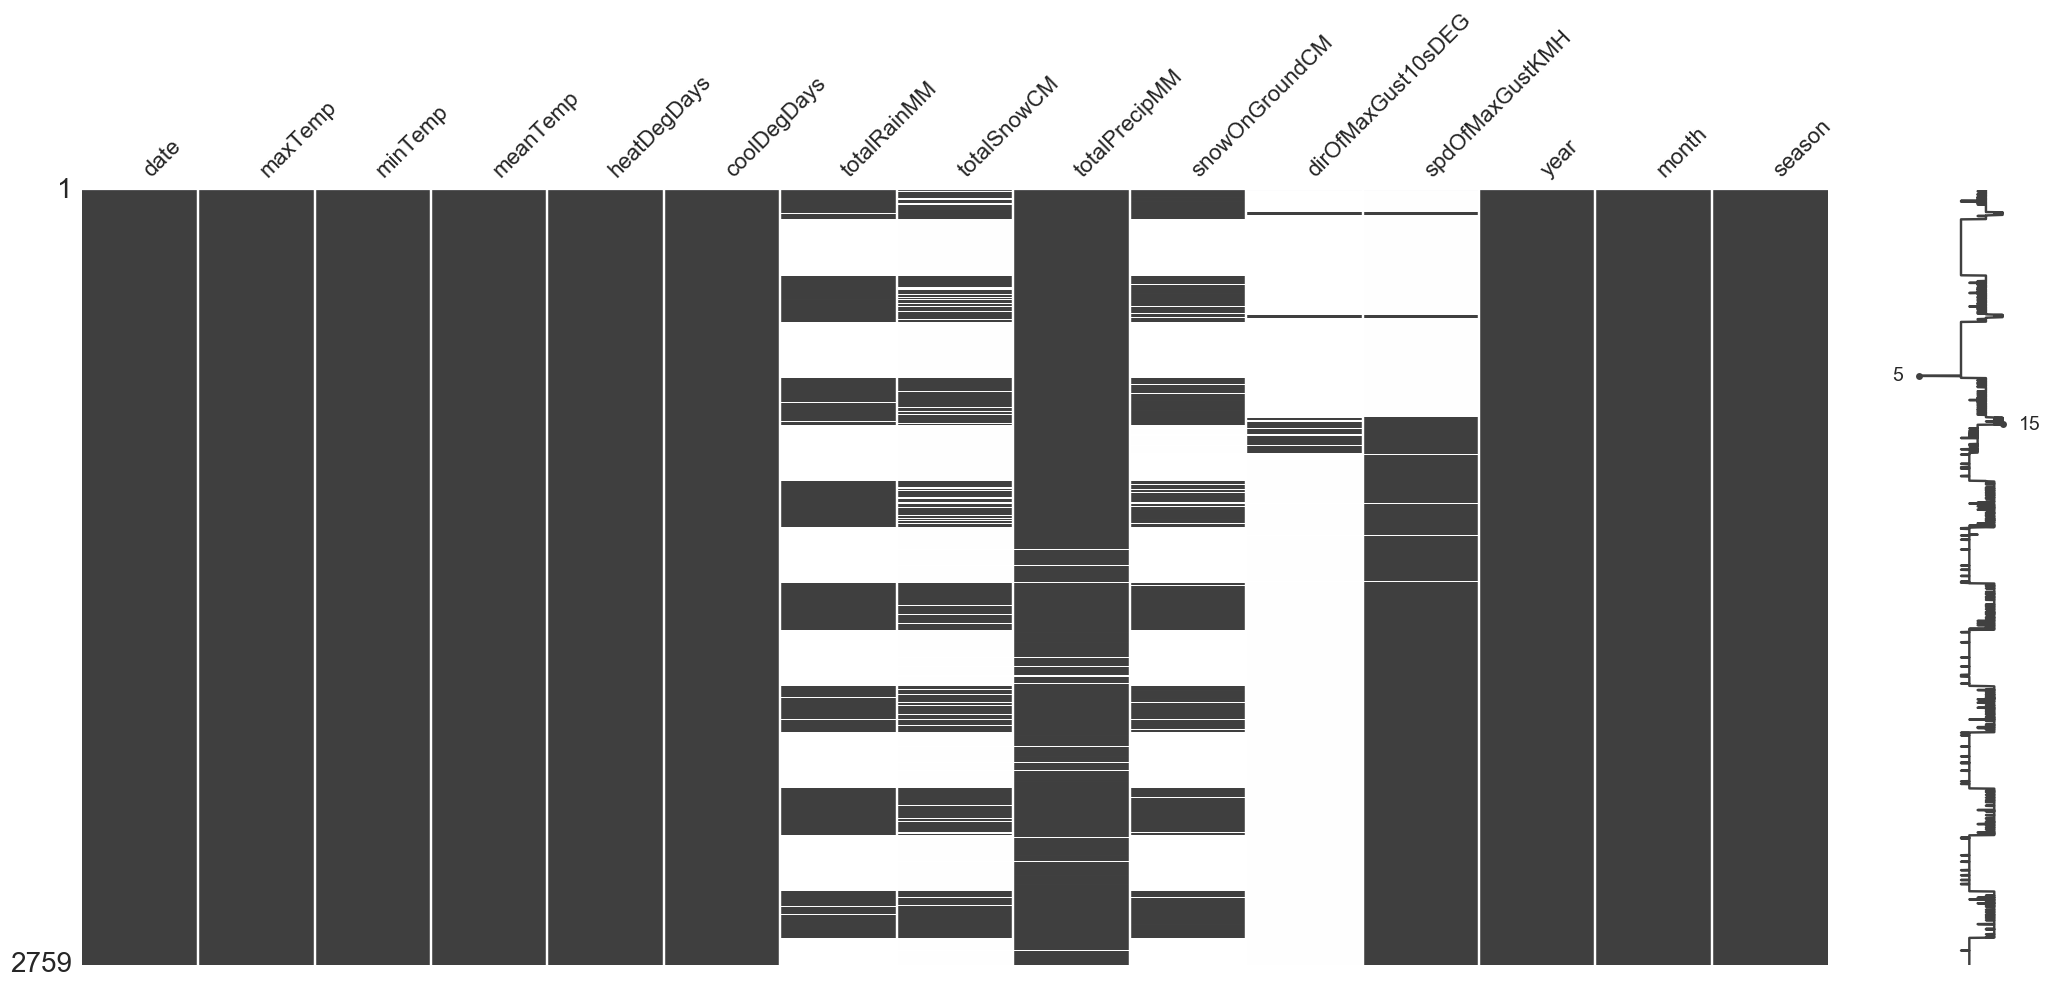

In [8]:
msno.matrix(df.sort_values('date', ascending=True))

#### Which months have the most missing precipitation records? 

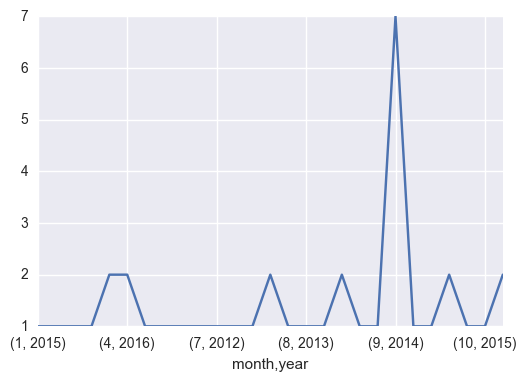

In [9]:
df[df.totalPrecipMM.isnull()].groupby(['month', 'year']).size().plot();

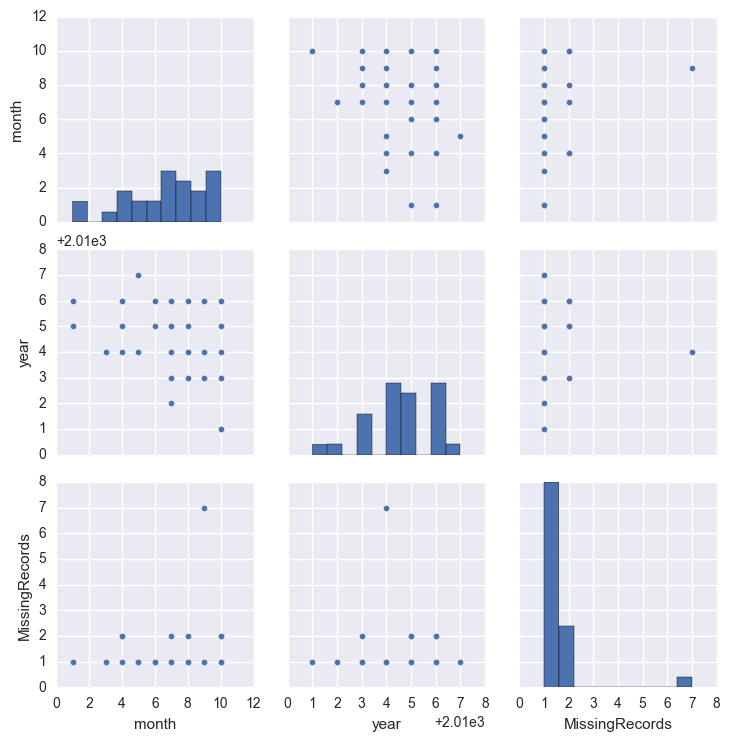

In [10]:
sns.pairplot(df[df.totalPrecipMM.isnull()].groupby(
    ['month', 'year']).size().reset_index().rename(columns={0: "MissingRecords"}));

We've only had one or two missing records for a while except in 2014 when there were 7 missing records.  Both the pairplot (above) and the line plot (above above) show this well.  There appears to be correlation between the month of the year and the total number of missing records, perhaps because of sensor failure in cold conditions.

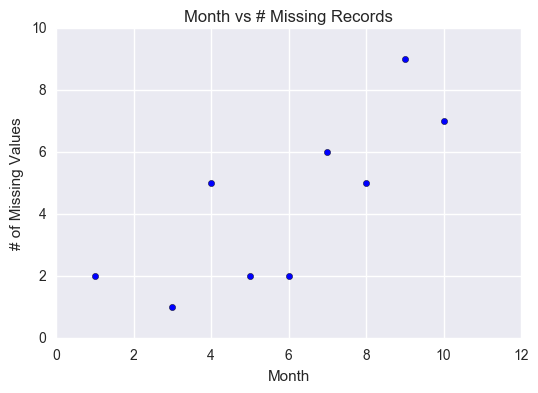

In [12]:
d = df[df.totalPrecipMM.isnull()].groupby(
  ['month']).size().reset_index().rename(columns={0: "MissingRecords"})
plt.scatter(d.month, d.MissingRecords)
plt.title("Month vs # Missing Records")
plt.xlabel("Month")
plt.ylabel("# of Missing Values");

Compute summary statistics for missing values

In [13]:
max_missing_vars = df.isnull().sum(axis=1).sort_values(ascending=False).values[0]
max_missing_day = df.loc[df.isnull().sum(axis=1).sort_values(ascending=False).head(1).index, 'date'].values[0]
max_missing_day_perc = int(round(max_missing_vars / len(df.columns) * 100, 0))
print("Number of variables: %s" % len(df.columns))
print("Highest number of missing values: {}/{}".format(max_missing_vars, len(df.columns)))
print("Highest % of missing measurements: {}".format(max_missing_day_perc))
print("Day with highest number of missing values: %s" % pd.to_datetime(max_missing_day).date())

Number of variables: 15
Highest number of missing values: 10/15
Highest % of missing measurements: 67
Day with highest number of missing values: 2011-10-24


Out of {{len(df)}} measurements, the maximum number of missing values for a day is {{max_missing_vars}} ({{max_missing_day_perc}}% of the variables) which was observed on {{str(pd.to_datetime(max_missing_day).date())}}.  We can safely ignore this single missing observation.

Rainfall looks to be systematically missing but other variables look okay.  Since the data is sorted by the date column in the matrix show above, it's obvious that rainfall data is missing _periodically_.  We can plot the values over time to get a better look at the missing rainfall data.

### 2.1 Missing rainfall trends

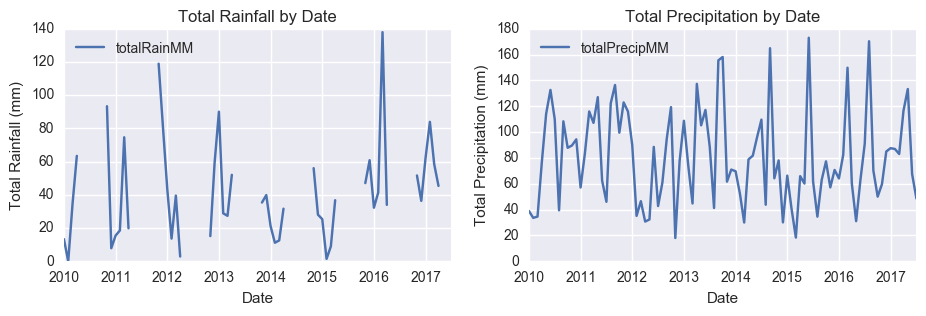

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(11,3))
# Total rainfall
df[['date', 'totalRainMM']].set_index('date').resample('1M').sum().plot(ax=ax1);
ax1.set_title("Total Rainfall by Date")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Rainfall (mm)");
# Total precipitation
df[['date', 'totalPrecipMM']].set_index('date').resample('1M').sum().plot(ax=ax2);
ax2.set_title("Total Precipitation by Date")
ax2.set_xlabel("Date")
ax2.set_ylabel("Total Precipitation (mm)");

The graph on the left shows that rainfall data is systematically missing for mid-year months.  From the graph on the right, we can begin to see how precipitation in 2016 and 2017 has been higher, on average compared to previous years.  It is also evident that there is a positive trend from ~ Feb 2015 to July 2017.

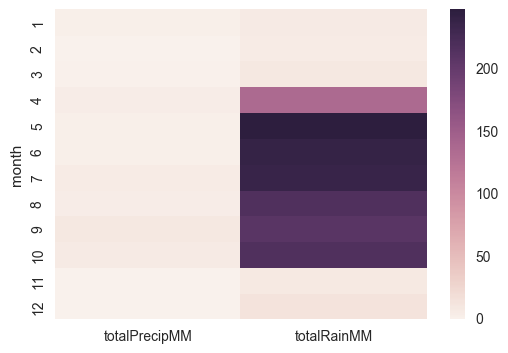

In [15]:
d = df[['month', 'totalPrecipMM', 'totalRainMM']].groupby(['month'])[['totalPrecipMM', 'totalRainMM']]
d = d.apply(lambda x: pd.isnull(x).sum())
sns.heatmap(d);

April through October is missing rain measurements year-over-year.  This isn't a big deal since any observed precipitation in this period is likely rain.  The [Rain Analysis and Count Modelling notebook](#) provides more information about the missing values and handles them appropriately before continuing with further modelling efforts.

## 3. Multivariate Data Analysis
We'll look at the distributions of each variable simultaneously to evaluate distributions and relationships.  The table below describes statistical properties of the daily weather observations and the pair plot visualizes marginal and conditional distributions of the continuous (numerical) observations.

In [16]:
cont_vars = [
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp',
  'totalPrecipMM',
  'totalRainMM'
]
df[cont_vars].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
minTemp,2759.0,3.423215,10.081919,-29.65,-3.3,3.500,11.7000,24.6
meanTemp,2758.0,8.394652,10.702823,-23.85,0.2,8.975,17.6875,30.7
maxTemp,2758.0,13.351994,11.609987,-18.90,3.6,14.550,23.7500,36.7
totalPrecipMM,2720.0,2.702463,6.161120,0.00,0.0,0.100,2.3500,69.7
totalRainMM,1208.0,1.585596,4.502499,0.00,0.0,0.000,0.2000,39.3


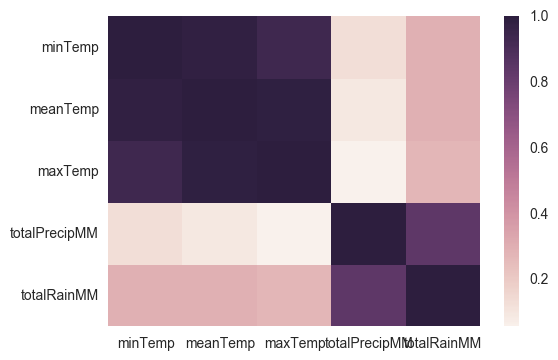

In [17]:
sns.heatmap(df[cont_vars].corr())

Strong correlation between temperature measurements and between precipitation/rain measurements

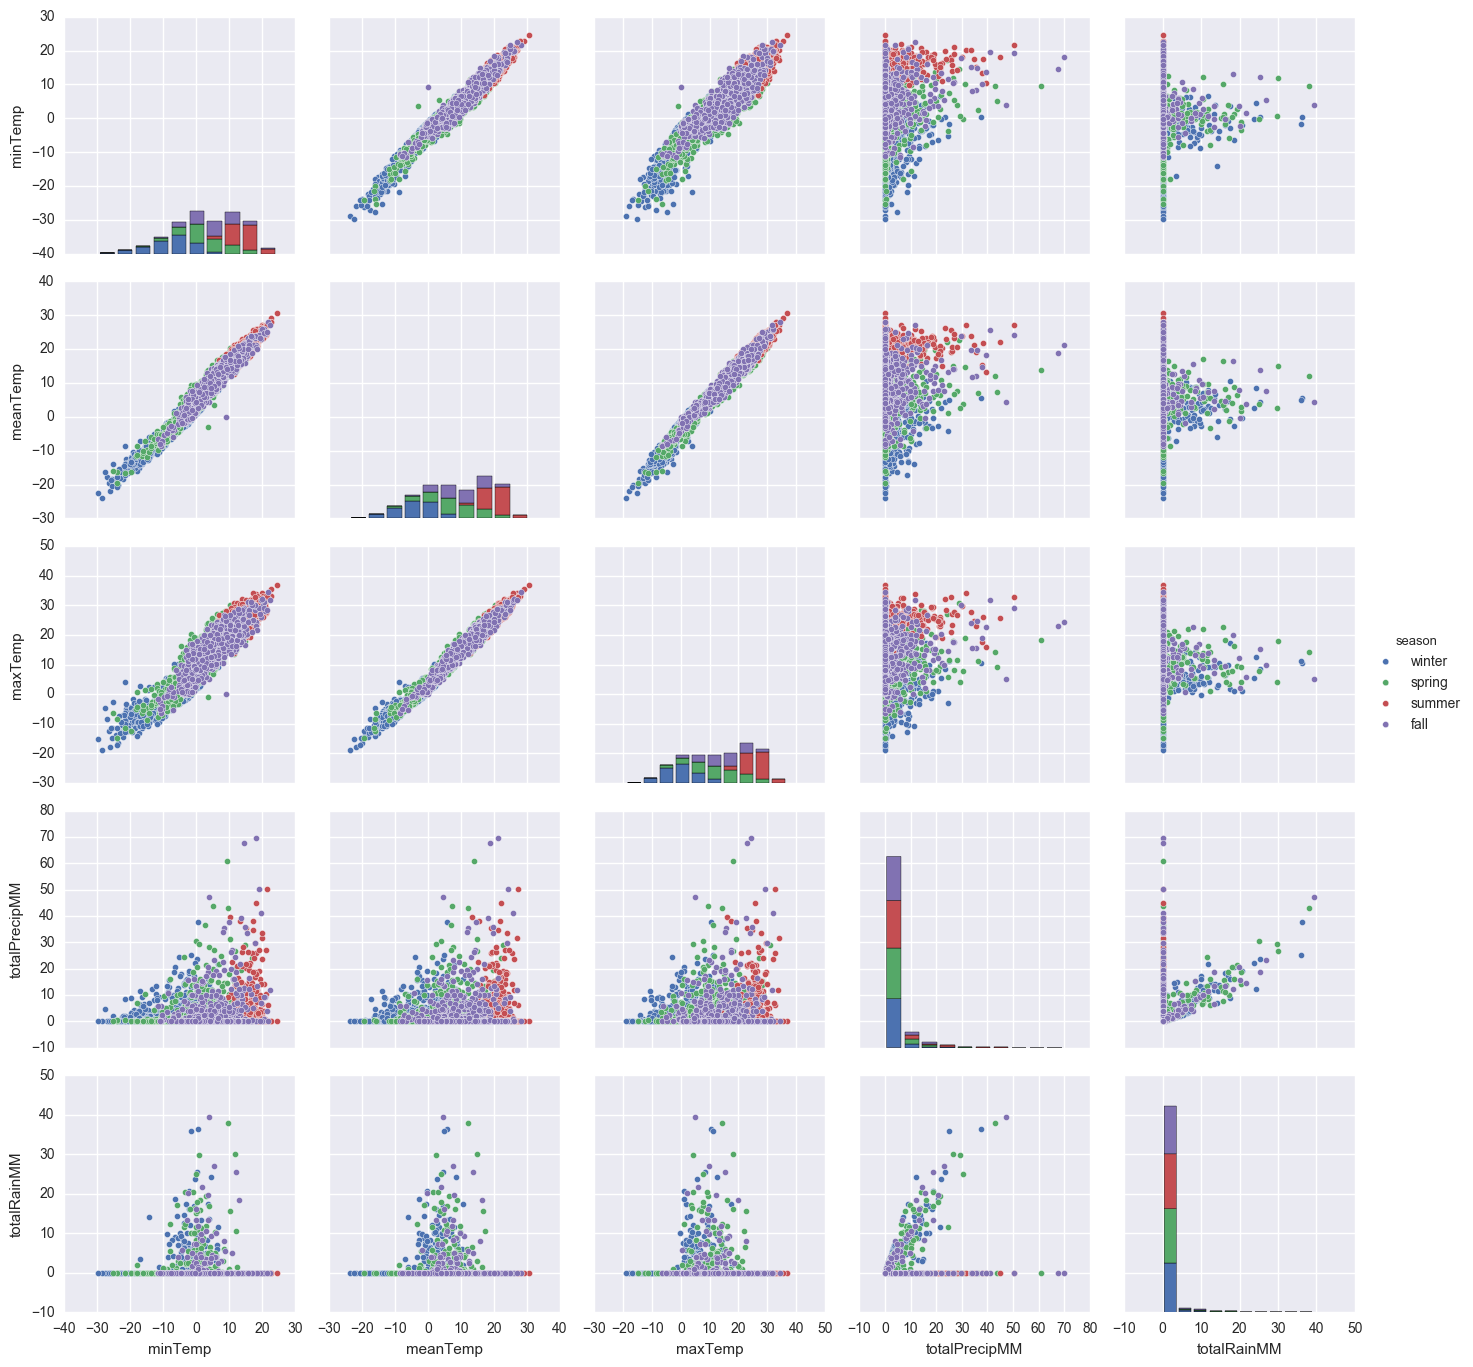

In [18]:
sns.pairplot(df[cont_vars].fillna(0), hue='season', size=2.75);

* Temperature distributions are bimodal, likely accounting for different seasons
* Precipitation is mildly correlated with precipitation i.e. higher temperatures correspond to more precipitation.  Intuitively, we usually observe more rainy days than snow days.  Both rain and snow are forms of precipitation.
* Precipitation appears to be [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution) distributed

It would be interesting to examine days with large differences between minimum and maximum temperatures but it's out of scope for this analysis.

### 3.1 Temperature and precipitation

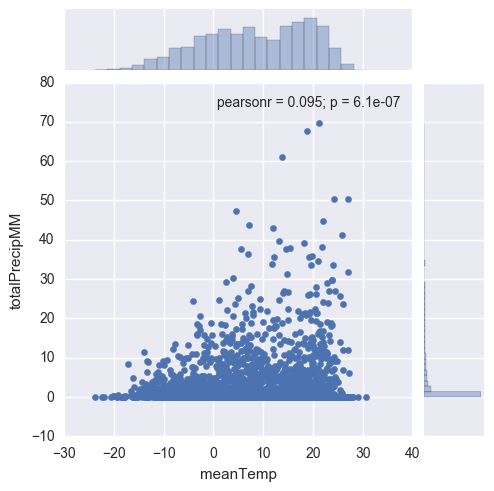

In [19]:
sns.jointplot(x="meanTemp", y="totalPrecipMM", data=df[['totalPrecipMM', 'meanTemp']], size=5);

Plot without zeros

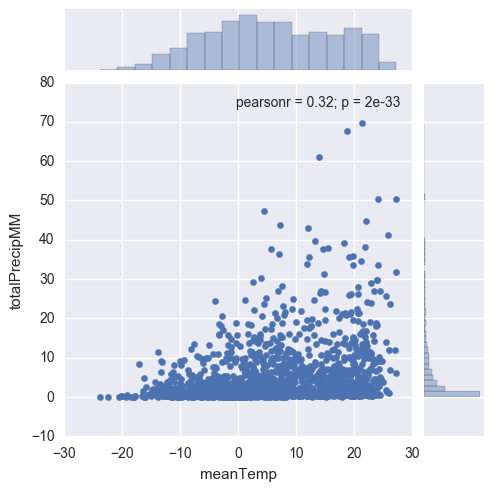

In [20]:
sns.jointplot(
  x="meanTemp", y="totalPrecipMM", data=df[['totalPrecipMM', 'meanTemp']].query('totalPrecipMM != 0'), size=5);

### 3.2 Seasonal distributions

In [21]:
temp_cols = [
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp'
]

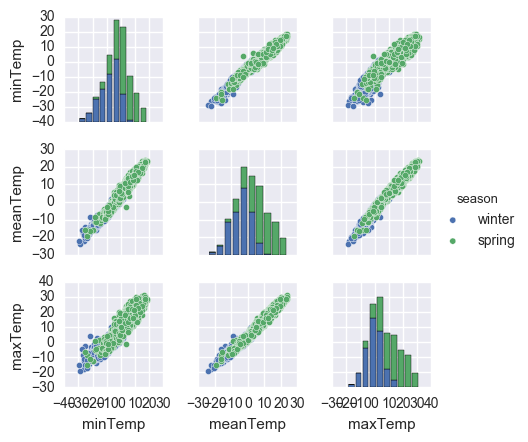

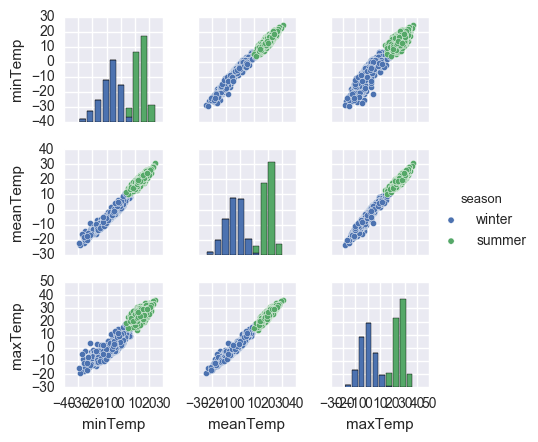

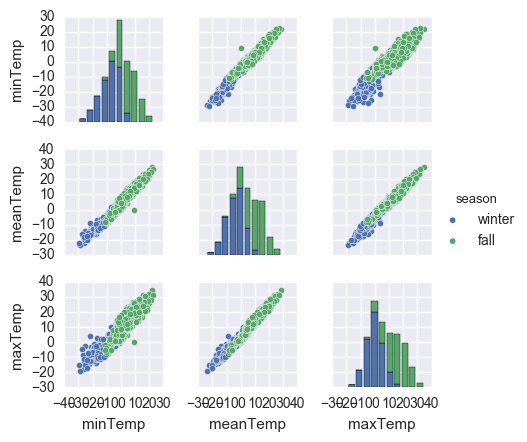

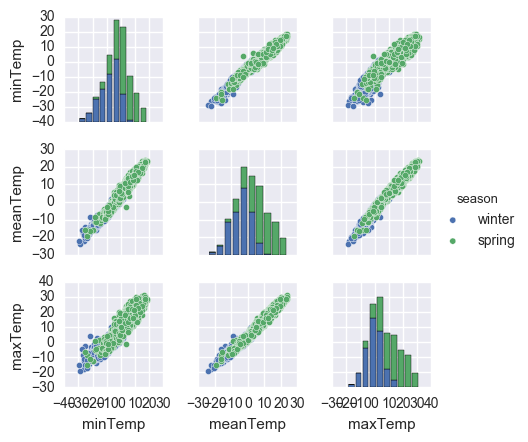

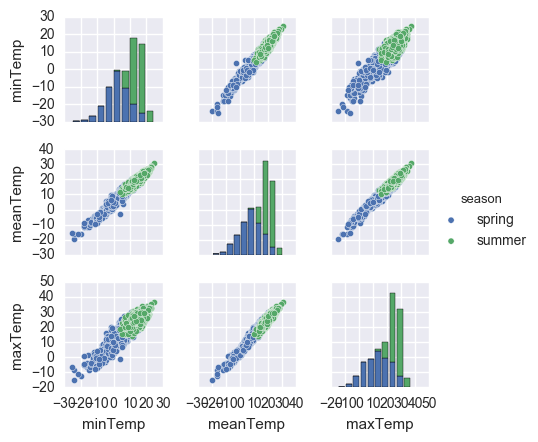

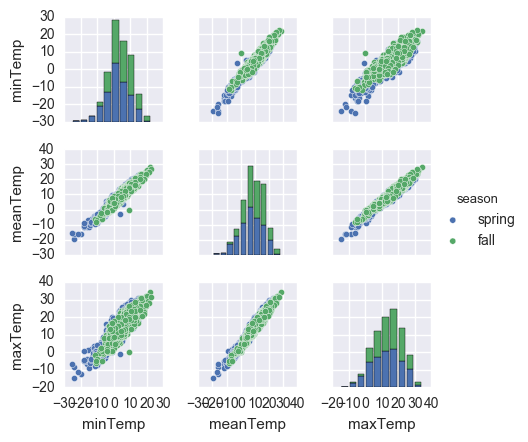

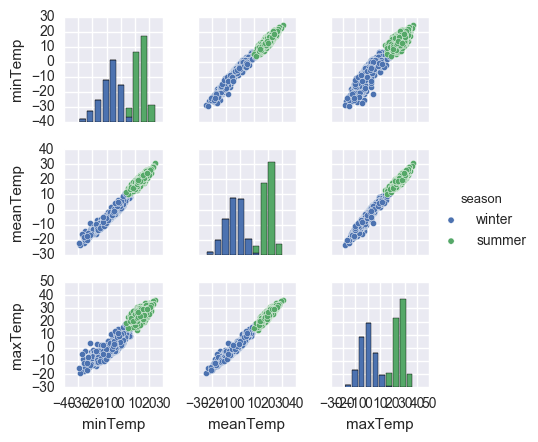

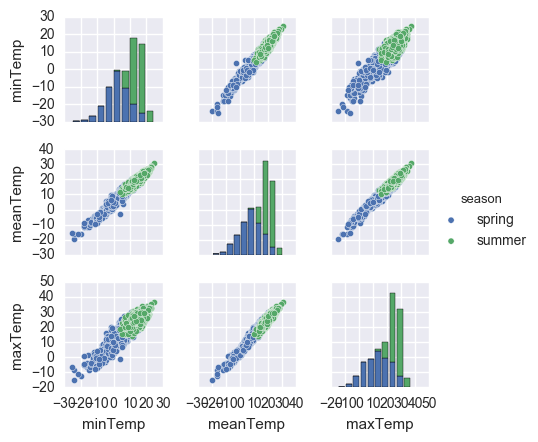

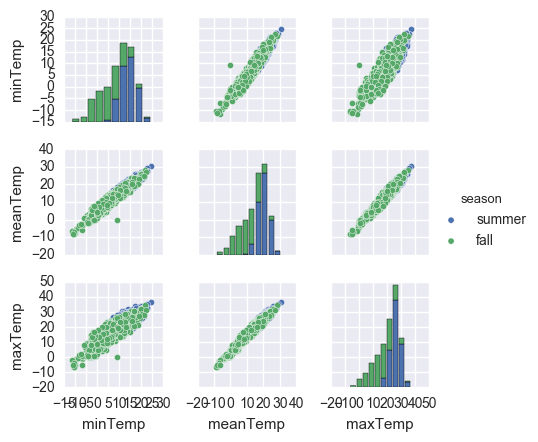

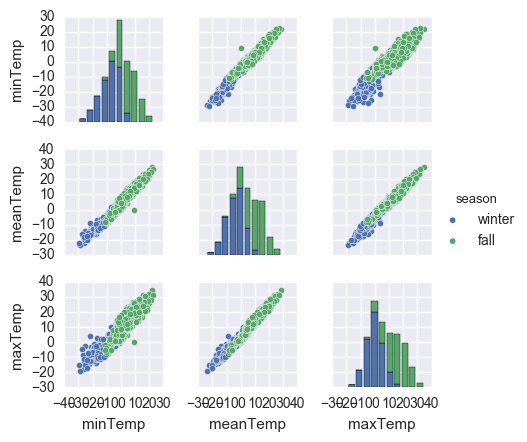

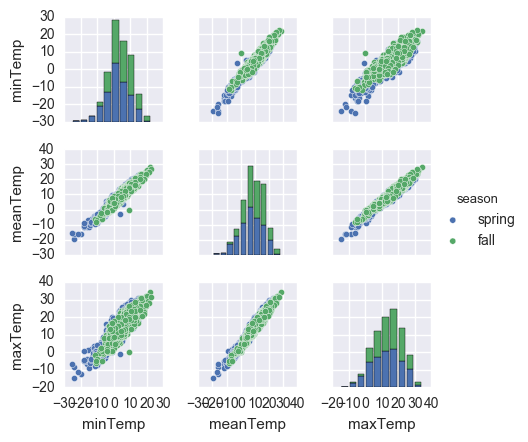

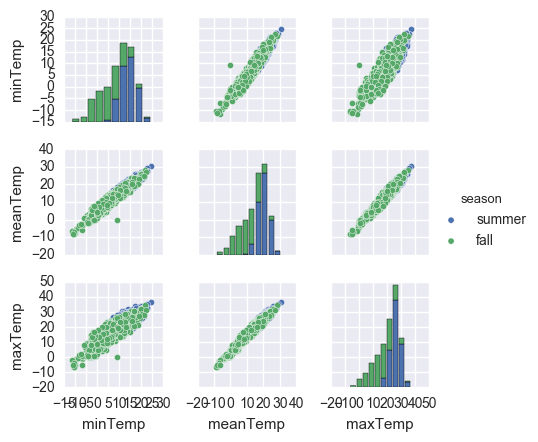

In [25]:
for x in filter(lambda x: x[0] != x[1], itertools.product(df.season.unique(), df.season.unique())):
  _ = sns.pairplot(df.loc[df.season.isin([x[0], x[1]]), temp_cols].fillna(0), hue='season', size=1.5)

As expected:
  - Winter and spring temperature distirbutions are normal and some overlap with all observed values observed in spring
  - Winter and summer temperature distirbutions are normal very share little overlap
  - Winter and fall look like winter/spring
  - 

#### Winter and Summer
There is a clear boundary between temperature values - the values cluster into two normal distributions with minimal overlap

Some overlap with slightly different mean temperatures with more variability in fall measurements since fall is like a "transitional" month.

Similar observations to fall-winter relationship

Average summer temperature is naturally much higher than the average spring temperature and there appears to be less variability.

#### Relationship between _spring and fall_ temperatures

In [ ]:
sns.pairplot(df.loc[df.season.isin(['spring', 'fall']), cols].fillna(0), hue='season', size=1.5);

As expected, spring and fall overlap significantly with each other and winter and summer seasons.  What about precipitation?

In [ ]:
precip_cols = [
  'season',
  'totalPrecipMM',
  'totalRainMM'
]
sns.pairplot(df.loc[df.season.isin(['fall', 'spring']), precip_cols].query(
    "(totalRainMM != 0) & (totalPrecipMM != 0)").fillna(0), hue='season');

## Precipitation and Temperature Changes Over Time

Temperatures by season/year

In [ ]:
fig, ax = plt.subplots(1, 2)
d = df.query("(year == {}) & (season == '{}')".format(c[0], c[1])).groupby('month').meanTemp.mean().reset_index()
_ = d.meanTemp.plot(ax=ax[i])

In [ ]:
for i, y in enumerate(years):
  for j, s in enumerate(seasons):
    print(y,s)
    print(i,j)

In [ ]:
seasons = df.season.unique()
years = df.year.unique()
charts = list(itertools.product(years, seasons))
fig, ax = plt.subplots(len(years), len(seasons), figsize=(15,10))
for i, y in enumerate(years):
  for j, s in enumerate(seasons):
    d = df.query("(year == {}) & (season == '{}')".format(y, s)).groupby('month').meanTemp.mean().reset_index()
    _ = d.meanTemp.plot(ax=ax[i,j])
    plt.xticks(d.index)
#   _.axhline(y=d.mean(), xmin=-1, xmax=1, c="red", linewidth=1.5, linestyle="--")
#   _.set_title("{} (mean={:.2f} days)".format(y, d.mean()))
plt.tight_layout()

#### NOTES
* Normals available at http://climate.weather.gc.ca/climate_normals/results_1981_2010_e.html?stnID=4789&autofwd=1